    
# Python for scientific computing

<a href="https://lb-aps-frontend.statista.com/chart/21017/most-popular-programming-languages/" title="Infographic: Python Remains Most Popular Programming Language | Statista"><img src="https://cdn.statcdn.com/Infographic/images/normal/21017.jpeg" alt="Infographic: Python Remains Most Popular Programming Language | Statista" width="50%" height="auto" style="width: 50%; height: auto !important; max-width:960px;-ms-interpolation-mode: bicubic;"/></a> You will find more infographics at <a href="https://lb-aps-frontend.statista.com/chartoftheday/">Statista</a>


<img src="bilder/data-scientist-skills-statistics-966x807.jpeg" width=500>

<font size="4">
<ul>
  <li>Python is today usually considered the most popular programming language in the world for scientific computing</li>
  <li>With over 25 million users worldwide, Anaconda Python is the most poplar edition of Python for scientific computing</li>
  
</ul>    
</font>
    

For example, I am using Anaconda Python to run this Jupyter notebook. With conda I can set up different environments for computing. This environment is named fortran, because I have a fortran compiler installed here.

<div class="alert alert-info">
    <h4>Some facts</h4>
    <ul>
        <li>Python is written in C!</li>
    <li>Python became popular for scientific computing when scientists discovered that it was very easy to wrap existing and fast Fortran libraries (like BLAS, LAPACK etc.), and call them from Python </li>
        <li>Prof Hans Petter Langtangen was one of the first scientist that helped making Python popular around year 2000</li>
    </ul>
</div>

# How about computational speed?

Python in itself is not very fast, but there are excellent and easy to use tools for optimizations. Lets consider the dot-product between two vectors $\mathbf{u}$ and $\mathbf{v}$

$$
\begin{align*}
\mathbf{u} &= (u_0, u_1, \ldots, u_{N-1}) \\
\mathbf{v} &= (v_0, v_1, \ldots, v_{N-1}) \\
c &= \mathbf{u} \cdot \mathbf{v} = \sum_{i=0}^{N-1}u_i v_i
\end{align*}
$$

We use the [Numpy](https://numpy.org) module for scientific computing with arrays.

In [26]:
import numpy as np
N = 1000000
u = np.random.random(N)
v = np.random.random(N)

First a naive Python implementation of the dot product

In [27]:
def dot(a, b):
    c = 0.0
    N = a.shape[0]
    for i in range(N):
        c += a[i]*b[i]
    return c

In [28]:
%timeit c = dot(u, v)

244 ms ± 26.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


How fast is this? Compared with fortran or C? It's actually pretty slow:-(

However, there are numerous alternative options. We can compute it using a vectorized elementwise multiplication and sum:

In [29]:
%timeit c = np.sum(u*v)

555 µs ± 16.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


So vectorization is much much faster than for-loops in Python.

[Numpy](https://numpy.org) also has its own [dot](https://numpy.org/doc/stable/reference/generated/numpy.dot.html) function:

In [30]:
%timeit c = np.dot(u, v)

217 µs ± 8.54 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Wow, that's fast! It's actually faster than I can do it in fortran, as you will see soon. The reason is that it is using BLAS under the hood. We can actually use BLAS directly, but it should not be faster

In [31]:
from scipy import linalg
ddot = linalg.get_blas_funcs('dot', (u, v))

In [32]:
%timeit c = ddot(u, v)

217 µs ± 20.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Think Fortran can do better? Lets try using Fortran's [dot_fortran](https://gcc.gnu.org/onlinedocs/gcc-4.7.4/gfortran/DOT_005fPRODUCT.html) and also show how to call it from Python

In [33]:
%%file dot_fortran.f90
      function dot_fortran(a,b,N) result(c)
      integer :: N
      real(8), dimension(N) :: a, b
      real(8) :: c
      c = dot_product(a, b)
      end function dot_fortran

Overwriting dot_fortran.f90


In [34]:
!cat dot_fortran.f90

      function dot_fortran(a,b,N) result(c)
      integer :: N
      real(8), dimension(N) :: a, b
      real(8) :: c
      c = dot_product(a, b)
      end function dot_fortran


We can compile this Fortran function and make it directly callable from Python. This is how many Python functions are implemented for speed.

In [35]:
!python -m numpy.f2py -c dot_fortran.f90 -m dotf

running build
running config_cc
INFO: unifing config_cc, config, build_clib, build_ext, build commands --compiler options
running config_fc
INFO: unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
running build_src
INFO: build_src
INFO: building extension "dotf" sources
INFO: f2py options: []
INFO: f2py:> /tmp/tmpetm7rbl9/src.linux-x86_64-3.9/dotfmodule.c
creating /tmp/tmpetm7rbl9/src.linux-x86_64-3.9
Reading fortran codes...
	Reading file 'dot_fortran.f90' (format:fix)
Post-processing...
	Block: dotf
			Block: dot_fortran
Applying post-processing hooks...
  character_backward_compatibility_hook
Post-processing (stage 2)...
Building modules...
    Building module "dotf"...
    Generating possibly empty wrappers"
    Maybe empty "dotf-f2pywrappers.f"
		Creating wrapper for Fortran function "dot_fortran"("dot_fortran")...
        Constructing wrapper function "dot_fortran"...
          c = dot_fortran(a,b,[n])
    Wrote C/API module "dotf" to file "/tmp/

In [36]:
import dotf
%timeit c = dotf.dot_fortran(u, v)

939 µs ± 5.97 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Ok, I can probably do better

In [37]:
%%file dot_fortran2.f90
      function dot_fortran(a,b,N) result(c)
      integer :: N
      real(8), dimension(N) :: a,b
      real(8) :: c
Cf2py intent(in) N
Cf2py intent(in) a
Cf2py intent(in) b
Cf2py intent(out) c
      c = dot_product(a,b)
      end function dot_fortran

Overwriting dot_fortran2.f90


In [38]:
%%capture
!python -m numpy.f2py -c dot_fortran2.f90 -m dotf2 --f90flags='-Ofast'

In [39]:
import dotf2
%timeit c = dotf2.dot_fortran(u, v)

957 µs ± 35.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Still not close to Numpy and BLAS. Lets try pure Fortran. Create a pure Fortran program, compile and run it from bash. 

In [40]:
%%file test_dot_fortran.f90
program test_dot
    real(8) :: t0,t1,c
    real(8), allocatable :: a(:), b(:)
    integer :: n
    character(len=12) :: arg
    call get_command_argument(1, arg)
    read(arg,*) n
    allocate (a(1:n))
    allocate (b(1:n))
    call random_number(a)
    call random_number(b)
    call cpu_time(t0)
    c = dot_product(a, b)
    call cpu_time(t1)
    write(*,*) "time ",(t1-t0)*1000," milliseconds ",c
end program test_dot

Overwriting test_dot_fortran.f90


In [41]:
!gfortran -Ofast -march=native test_dot_fortran.f90 -o test_dot_fortran
!./test_dot_fortran 1000000

 time   0.38299999999999446       milliseconds    250042.60508968838     


Try one more time, with explicit do-loop:

In [42]:
%%file dot_fortran3.f90
      function dot_fortran(a,b,N) result(c)
      integer :: N
      real(8), dimension(n) :: a,b
      real(8) :: c
Cf2py intent(in) N
Cf2py intent(in) a
Cf2py intent(in) b
Cf2py intent(out) c
      c = 0.0
      do i = 1,N
        c = c + a(i)*b(i)
      end do
      end function dot_fortran

Overwriting dot_fortran3.f90


In [43]:
%%capture
!python -m numpy.f2py -c dot_fortran3.f90 -m dotf3 --f90flags='-Ofast -march=native' -DF2PY_REPORT_ON_ARRAY_COPY=1

In [44]:
import dotf3
%timeit c = dotf3.dot_fortran(u, v)

941 µs ± 3.73 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Ok. I'm not able to make Fortran faster. Perhaps I'm not the best Fortran programmer, or I simply do not have the best fortran compiler. 

<div class="alert alert-info">
The point is that it is trivially simple to wrap a Fortran function and call it from Python!
</div>

What else is there?

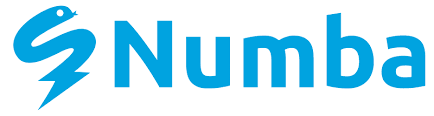
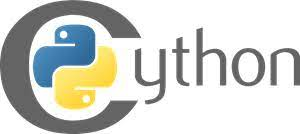


[Numba](https://numba.pydata.org) is an open source JIT (Just-In-Time) compiler that translates a subset of Python and NumPy code into fast machine code, using the [LLVM](https://llvm.org) compiler.

Lets optimize the Python dot-product using Numba. To this end we simply add a decorator, asking Numba to create machine code and compile it. 

In [45]:
import numba as nb

@nb.jit(nopython=True, fastmath=True, parallel=True)  # <- decorator function
def nbdot(a, b):
    c = 0.0
    N = a.shape[0]
    for i in nb.prange(N):
        c += a[i]*b[i]
    return c

Run it once to generate code

In [46]:
c = nbdot(u, v) 

In [47]:
%timeit c = nbdot(u, v)

222 µs ± 22.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# Cython

Cython is an optimising static compiler for both the Python programming language and the extended Cython programming language. It is similar to Python, but with strong typing, and it has to be compiled.

In [48]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [49]:
%%cython
cimport cython 

@cython.boundscheck(False)
@cython.wraparound(False)
def cydot(double[::1] a, double[::1] b):
    cdef:
        double c = 0.0
        int i, N = a.shape[0]
    for i in range(N):
        c = c + a[i]*b[i]
    return c

In [50]:
%timeit c = cydot(u, v)

947 µs ± 18.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
